This file includes all code source and data for report section "Feature influence analysis"

In [22]:
import os
from os.path import exists
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob


#Path to files with feature data
file_features = 'features/features_original.csv'
file_data = '..' + os.sep + 'data' + os.sep + 'metadata.csv'
df_features = pd.read_csv(file_features)
metadata_df = pd.read_csv(file_data)

#Merging created annotations with patiend details
combined_df = df_features.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')
if combined_df.isnull().values.any():
    raise ValueError("NaN values detected after merge! Check the data integrity.")

#Changing diagnosis to binary(cancerous/not cancerous)
combined_df['diagnostic'] = combined_df['diagnostic'].replace(['BCC', 'MEL', 'SCC'], 1)
combined_df['diagnostic'] = combined_df['diagnostic'].replace(['NEV', 'ACK', 'SEK'], 0)


In [5]:
#Calculation of corelation matrix
correlation_matrix = combined_df[['asymmetry', 'compactness', 'dots and globules', 'colours', 'diagnostic']].corr()
print(correlation_matrix['diagnostic'])

asymmetry           -0.000048
compactness         -0.008214
dots and globules    0.134804
colours              0.075571
diagnostic           1.000000
Name: diagnostic, dtype: float64


<Axes: xlabel='diagnostic', ylabel='dots and globules'>

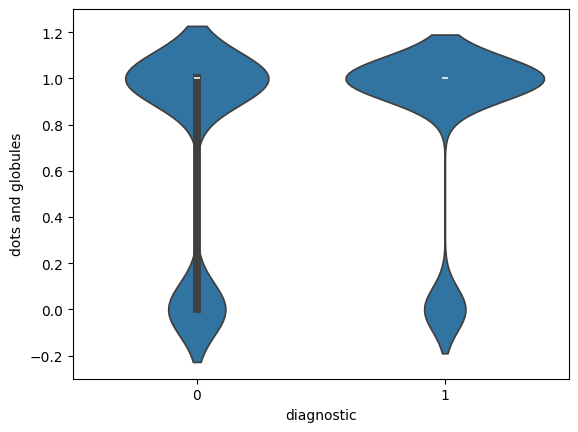

In [6]:
#Analysis of dots and globules depending on diagnosis
sns.violinplot(combined_df[['dots and globules','diagnostic']], x="diagnostic", y="dots and globules")

<Axes: xlabel='diagnostic', ylabel='colours'>

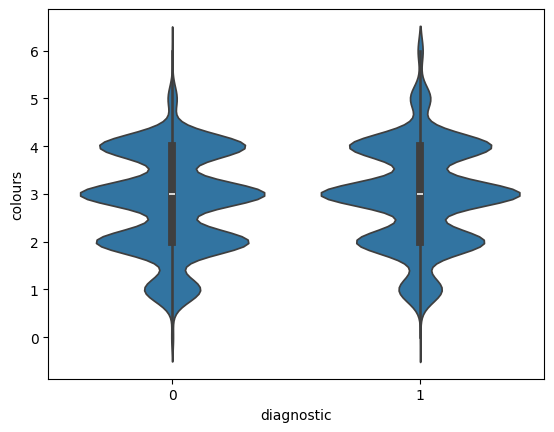

In [34]:
#Analysis of colours number depending on diagnosis
sns.violinplot(combined_df[['colours','diagnostic']], x="diagnostic", y="colours")

<Axes: xlabel='diagnostic', ylabel='compactness'>

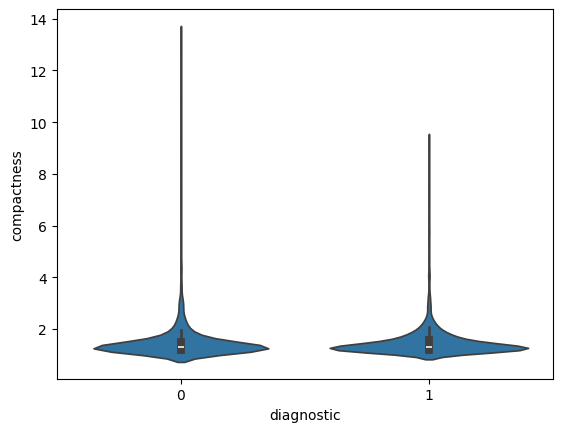

In [10]:
#Analysis of compactness depending on diagnosis
sns.violinplot(combined_df[['compactness','diagnostic']], x="diagnostic", y="compactness")

<Axes: xlabel='diagnostic', ylabel='asymmetry'>

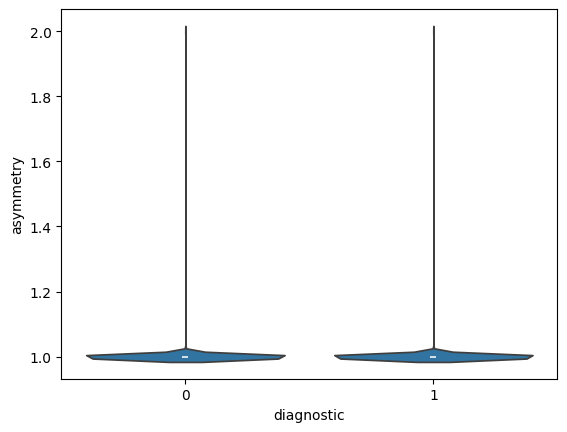

In [12]:
#Analysis of asymmetry depending on diagnosis
sns.violinplot(combined_df[['asymmetry','diagnostic']], x="diagnostic", y="asymmetry")

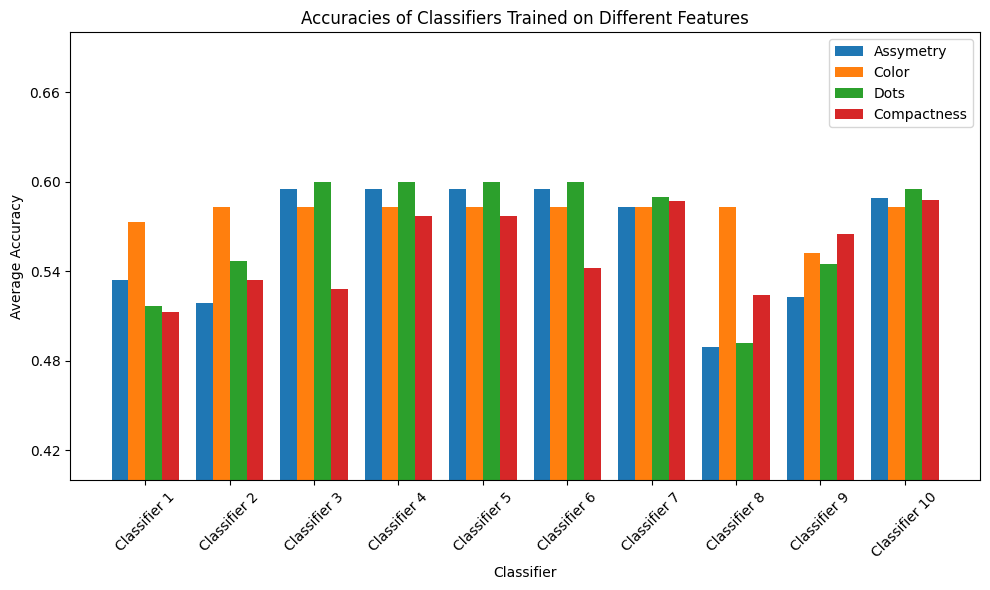

In [14]:
############Notation for clasifiers
#Classifier 1: KNeighborsClassifier(1)
#Classifier 2: KNeighborsClassifier(5)
#Classifier 3: RandomForestClassifier
#Classifier 4: GradientBoostingClassifier
#Classifier 5: AdaBoostClassifier
#Classifier 6: DecisionTreeClassifier
#Classifier 7: Logistic Regression
#Classifier 8: Logistic Regression (balanced)
#Classifier 9: SGD Classifier
#Classifier 10: GaussianNB


# Average accuracies for each feature
average_accuracies = {
    "Assymetry": [0.534, 0.519, 0.595, 0.595, 0.595, 0.595, 0.583, 0.489, 0.523, 0.589],
    "Color": [0.573, 0.583, 0.583, 0.583, 0.583, 0.583, 0.583, 0.583, 0.552, 0.583],
    "Dots": [0.517, 0.547, 0.6, 0.6, 0.6, 0.6, 0.59, 0.492, 0.545, 0.595],
    "Compactness": [0.513, 0.534, 0.528, 0.577, 0.577, 0.542, 0.587, 0.524, 0.565, 0.588]
}

# Classifier names
classifiers = [f"Classifier {i}" for i in range(1, 11)]

# Number of classifiers and features
num_classifiers = len(classifiers)
num_features = len(average_accuracies)

# Bar width
bar_width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(num_classifiers)

# Plotting each feature's average accuracies as a grouped bar plot
for i, (feature, accuracies) in enumerate(average_accuracies.items()):
    ax.bar(x + i * bar_width, accuracies, bar_width, label=feature)

# Setting labels and title
ax.set_xlabel('Classifier')
ax.set_ylabel('Average Accuracy')
ax.set_title('Accuracies of Classifiers Trained on Different Features')
ax.set_xticks(x + (num_features - 1) * bar_width / 2)
ax.set_xticklabels(classifiers, rotation=45)
ax.legend()
ax.set_ylim(0.4, 0.7)
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
plt.show()


In [21]:

from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.inspection import permutation_importance  


feature_names = ['asymmetry', 'colours', 'dots and globules', 'compactness']

# Preparing the dataset
X = combined_df[feature_names].to_numpy()
y = np.logical_or(combined_df['diagnostic'] == 'BCC', np.logical_or(combined_df['diagnostic'] == 'MEL', combined_df['diagnostic'] == 'SCC'))
patient_id = combined_df['patient_id'].values

# List of classifier filenames
classifier_dir = 'Trained_classifiers'
classifier_filenames = glob.glob(os.path.join(classifier_dir, '*.sav'))

for model_filename in classifier_filenames:

    clf = pickle.load(open(model_filename, 'rb'))
    
    # Performing feature importance analysis
    print(f"Feature Importance for Classifier {model_filename} :")
    if hasattr(clf, 'feature_importances_'):
        feature_importances = clf.feature_importances_
        feature_importance_dict = dict(zip(feature_names, feature_importances))
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_feature_importance:
            print(f"{feature}: {importance}")
    elif isinstance(clf, LogisticRegression):
        coefficients = clf.named_steps['logisticregression'].coef_[0]
        feature_importance_dict = dict(zip(feature_names, np.abs(coefficients)))
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_feature_importance:
            print(f"{feature}: {importance}")

    else:
        result = permutation_importance(clf, X, y, n_repeats=10, random_state=42)
        feature_importance_dict = dict(zip(feature_names, result.importances_mean))
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_feature_importance:
            print(f"{feature}: {importance}")



C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator AdaBoostClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Gaussi

Feature Importance for Classifier Trained_classifiers\AdaBoost.sav :
compactness: 0.94
colours: 0.03
dots and globules: 0.02
asymmetry: 0.01
Feature Importance for Classifier Trained_classifiers\AdaBoost_fold_0.sav :
compactness: 0.91
colours: 0.06
dots and globules: 0.03
asymmetry: 0.0
Feature Importance for Classifier Trained_classifiers\AdaBoost_fold_1.sav :
compactness: 0.92
colours: 0.06
dots and globules: 0.02
asymmetry: 0.0
Feature Importance for Classifier Trained_classifiers\AdaBoost_fold_2.sav :
compactness: 0.92
colours: 0.05
dots and globules: 0.02
asymmetry: 0.01
Feature Importance for Classifier Trained_classifiers\AdaBoost_fold_3.sav :
compactness: 0.94
colours: 0.04
dots and globules: 0.02
asymmetry: 0.0
Feature Importance for Classifier Trained_classifiers\AdaBoost_fold_4.sav :
compactness: 0.94
colours: 0.03
dots and globules: 0.02
asymmetry: 0.01
Feature Importance for Classifier Trained_classifiers\DecisionTree.sav :
compactness: 0.8356589095051635
colours: 0.149513

C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


asymmetry: -0.0006082108464268265
compactness: -0.0019766852508870335
colours: -0.023720223010643738
dots and globules: -0.030005068423720284
Feature Importance for Classifier Trained_classifiers\KNeighbors (n=1)_fold_1.sav :


C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


compactness: 0.006335529650278715
asymmetry: -0.0006082108464268265
colours: -0.012620375063355348
dots and globules: -0.02149011657374563
Feature Importance for Classifier Trained_classifiers\KNeighbors (n=1)_fold_2.sav :


C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


compactness: 0.00385200202736945
asymmetry: -0.0005068423720223647
colours: -0.017181956411556055
dots and globules: -0.029954384186518024
Feature Importance for Classifier Trained_classifiers\KNeighbors (n=1)_fold_3.sav :


C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


compactness: 0.0005575266092245456
asymmetry: -0.0005575266092244901
colours: -0.01657374556512924
dots and globules: -0.025950329447541796
Feature Importance for Classifier Trained_classifiers\KNeighbors (n=1)_fold_4.sav :


C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


asymmetry: 0.0009123162696401566
compactness: -0.0032437911809427454
colours: -0.010897110998479476
dots and globules: -0.019817536746071996
Feature Importance for Classifier Trained_classifiers\KNeighbors (n=5).sav :


C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


compactness: 0.0015712113532691196
asymmetry: 0.0004561581348200283
colours: -0.024784591991890547
dots and globules: -0.02696401419158643
Feature Importance for Classifier Trained_classifiers\KNeighbors (n=5)_fold_0.sav :


C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


compactness: 0.004105423213380666
asymmetry: -0.00010136847440445074
dots and globules: -0.034211860111505274
colours: -0.041155600608210816
Feature Importance for Classifier Trained_classifiers\KNeighbors (n=5)_fold_1.sav :


C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


asymmetry: 0.0
compactness: -0.009427268119614751
dots and globules: -0.025544855549923938
colours: -0.03978712620375059
Feature Importance for Classifier Trained_classifiers\KNeighbors (n=5)_fold_2.sav :


C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


compactness: 0.00020273694880887927
asymmetry: -5.068423720223647e-05
dots and globules: -0.0238215914850482
colours: -0.03451596553471873
Feature Importance for Classifier Trained_classifiers\KNeighbors (n=5)_fold_3.sav :


C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


asymmetry: 0.0
compactness: -0.002382159148504759
colours: -0.024277749619868172
dots and globules: -0.025747592498732853
Feature Importance for Classifier Trained_classifiers\KNeighbors (n=5)_fold_4.sav :


C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


compactness: 0.0015712113532691196
asymmetry: 0.0004561581348200283
colours: -0.024784591991890547
dots and globules: -0.02696401419158643
Feature Importance for Classifier Trained_classifiers\LogisticRegression (Std).sav :
compactness: 0.0010136847440445518
asymmetry: 0.0
dots and globules: -0.00015205271160673162
colours: -0.00030410542321341883
Feature Importance for Classifier Trained_classifiers\LogisticRegression (Std)_fold_0.sav :
asymmetry: 0.0007602635580334471
dots and globules: 0.0007602635580334471
compactness: 0.0001520527116066761
colours: 0.0
Feature Importance for Classifier Trained_classifiers\LogisticRegression (Std)_fold_1.sav :
dots and globules: 0.00040547389761789174
asymmetry: 0.00025342118601119347
compactness: -0.00010136847440445074
colours: -0.0005068423720222537
Feature Importance for Classifier Trained_classifiers\LogisticRegression (Std)_fold_2.sav :
asymmetry: 0.0
colours: 0.0
dots and globules: 0.0
compactness: 0.0
Feature Importance for Classifier Train

C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from 

compactness: 0.0010136847440445518
asymmetry: 0.0
dots and globules: -0.00015205271160673162
colours: -0.00030410542321341883
Feature Importance for Classifier Trained_classifiers\LogisticRegression (Std, Balanced).sav :
compactness: -0.000608210846426771
asymmetry: -0.0007602635580334638
colours: -0.004967055245818563
dots and globules: -0.005524581855043098
Feature Importance for Classifier Trained_classifiers\LogisticRegression (Std, Balanced)_fold_0.sav :
colours: 0.0
compactness: 0.0
asymmetry: -0.0007602635580334638
dots and globules: -0.0007602635580334638
Feature Importance for Classifier Trained_classifiers\LogisticRegression (Std, Balanced)_fold_1.sav :
compactness: -5.068423720223092e-05
colours: -0.00010136847440446184
asymmetry: -0.0007602635580334638
dots and globules: -0.0007602635580334638
Feature Importance for Classifier Trained_classifiers\LogisticRegression (Std, Balanced)_fold_2.sav :
colours: 0.0
compactness: 0.0
asymmetry: -0.0007602635580334638
dots and globules

C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from 

colours: 0.0
compactness: 0.0
asymmetry: -0.0007602635580334638
dots and globules: -0.0007602635580334638
Feature Importance for Classifier Trained_classifiers\LogisticRegression (Std, Balanced)_fold_4.sav :
compactness: -0.000608210846426771
asymmetry: -0.0007602635580334638
colours: -0.004967055245818563
dots and globules: -0.005524581855043098
Feature Importance for Classifier Trained_classifiers\RandomForest.sav :
compactness: 0.9381441352701474
colours: 0.044345419321658926
dots and globules: 0.017102772632685618
asymmetry: 0.0004076727755081511
Feature Importance for Classifier Trained_classifiers\RandomForest_fold_0.sav :
compactness: 0.930707787598908
colours: 0.054163530669413665
dots and globules: 0.01421745634807873
asymmetry: 0.0009112253835994519
Feature Importance for Classifier Trained_classifiers\RandomForest_fold_1.sav :
compactness: 0.933790184525227
colours: 0.04636749723163023
dots and globules: 0.01905580286873456
asymmetry: 0.0007865153744083185
Feature Importance

C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from 

asymmetry: -5.068423720222537e-05
compactness: -0.012519006588950821
dots and globules: -0.0170299036999493
colours: -0.019158641662442986
Feature Importance for Classifier Trained_classifiers\SGDClassifier (Std)_fold_0.sav :
compactness: 0.000557526609224579
colours: 0.0005068423720223647
dots and globules: 2.2204460492503132e-17
asymmetry: 0.0
Feature Importance for Classifier Trained_classifiers\SGDClassifier (Std)_fold_1.sav :
dots and globules: 0.011150532184490613
colours: 0.009376583882412581
asymmetry: 0.00025342118601119347
compactness: -0.0016725798276735816
Feature Importance for Classifier Trained_classifiers\SGDClassifier (Std)_fold_2.sav :
compactness: 0.01028890015205276
asymmetry: -0.00010136847440445074
colours: -0.010035478966041534
dots and globules: -0.014242270653826628
Feature Importance for Classifier Trained_classifiers\SGDClassifier (Std)_fold_3.sav :
compactness: 0.016624429802331486
asymmetry: 0.00010136847440447294
colours: -0.014951849974657839
dots and glo

C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\maryz\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from versi

In [58]:
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.inspection import permutation_importance  


feature_names = ['assymetry', 'colours', 'dots and globules', 'compactness']
num_folds = 5

# Preparing the dataset
X = combined_df[feature_names].to_numpy()
y = np.logical_or(combined_df['diagnostic'] == 'BCC', np.logical_or(combined_df['diagnostic'] == 'MEL', combined_df['diagnostic'] == 'SCC'))
patient_id = combined_df['patient_id'].values

for j in range(1,len(classifiers)+1):

    # Loading the classifier
    fold_filename = f'classifier_{j}.sav'
    clf = pickle.load(open(fold_filename, 'rb'))
    
    # Performing feature importance analysis
    print(f"Feature Importance for Classifier {j} :")
    if hasattr(clf, 'feature_importances_'):
        feature_importances = clf.feature_importances_
        feature_importance_dict = dict(zip(feature_names, feature_importances))
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_feature_importance:
            print(f"{feature}: {importance}")
    elif isinstance(clf, LogisticRegression):
        coefficients = clf.named_steps['logisticregression'].coef_[0]
        feature_importance_dict = dict(zip(feature_names, np.abs(coefficients)))
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_feature_importance:
            print(f"{feature}: {importance}")

    else:
        result = permutation_importance(clf, X, y, n_repeats=10, random_state=42)
        feature_importance_dict = dict(zip(feature_names, result.importances_mean))
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_feature_importance:
            print(f"{feature}: {importance}")



Feature Importance for Classifier 1 :
compactness: 0.004510897110998479
assymetry: 0.000506842372022287
dots and globules: -0.026051697921946282
colours: -0.0295995945261024
Feature Importance for Classifier 2 :
compactness: 0.8904528646309968
colours: 0.060055643256343424
assymetry: 0.03274604511441224
dots and globules: 0.016745446998247586
Feature Importance for Classifier 3 :
compactness: 0.7808871562581309
colours: 0.10077382786752935
dots and globules: 0.09371187048632092
assymetry: 0.024627145388018825
Feature Importance for Classifier 4 :
compactness: 0.94
colours: 0.03
assymetry: 0.02
dots and globules: 0.01
Feature Importance for Classifier 5 :
compactness: 0.7498233756668915
colours: 0.13204216935661772
assymetry: 0.10493894732968048
dots and globules: 0.013195507646810255
Feature Importance for Classifier 6 :
compactness: 0.0009123162696401566
colours: 5.0684237202258674e-05
assymetry: 0.0
dots and globules: -0.0001520527116066539
Feature Importance for Classifier 7 :
compa

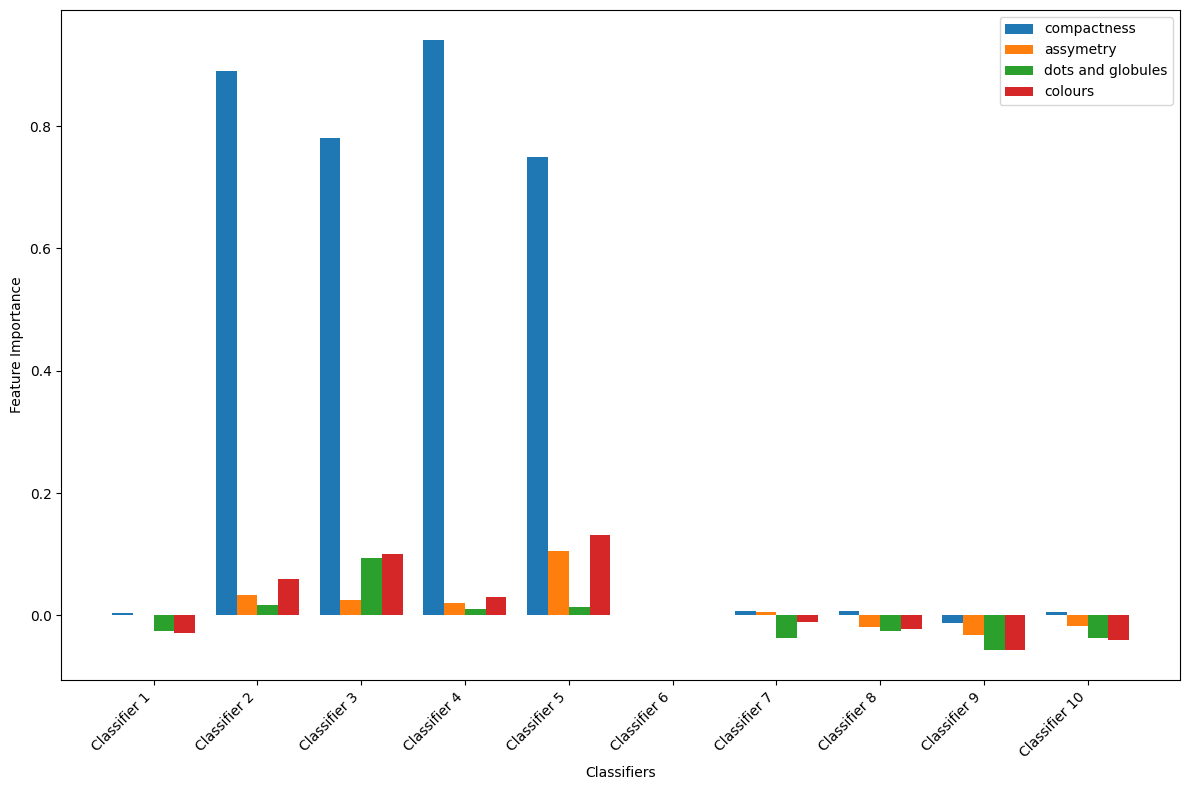

In [23]:

# Feature importance data
classifiers = [
    {"Classifier 1": {"compactness": 0.004510897110998479, "assymetry": 0.000506842372022287, "dots and globules": -0.026051697921946282, "colours": -0.0295995945261024}},
    {"Classifier 2": {"compactness": 0.8904528646309968, "colours": 0.060055643256343424, "assymetry": 0.03274604511441224, "dots and globules": 0.016745446998247586}},
    {"Classifier 3": {"compactness": 0.7808871562581309, "colours": 0.10077382786752935, "dots and globules": 0.09371187048632092, "assymetry": 0.024627145388018825}},
    {"Classifier 4": {"compactness": 0.94, "colours": 0.03, "assymetry": 0.02, "dots and globules": 0.01}},
    {"Classifier 5": {"compactness": 0.7498233756668915, "colours": 0.13204216935661772, "assymetry": 0.10493894732968048, "dots and globules": 0.013195507646810255}},
    {"Classifier 6": {"compactness": 0.0009123162696401566, "colours": 5.0684237202258674e-05, "assymetry": 0.0, "dots and globules": -0.0001520527116066539}},
    {"Classifier 7": {"compactness": 0.006741003547896612, "assymetry": 0.004865686771414102, "colours": -0.011150532184490608, "dots and globules": -0.036340598073998975}},
    {"Classifier 8": {"compactness": 0.007704004054738966, "assymetry": -0.01839837810440952, "colours": -0.021743537759756716, "dots and globules": -0.02574759249873291}},
    {"Classifier 9": {"compactness": -0.013076533198175389, "assymetry": -0.03269133299543844, "dots and globules": -0.056512924480486594, "colours": -0.0565129244804866}},
    {"Classifier 10": {"compactness": 0.005423213380638647, "assymetry": -0.018144956918398326, "dots and globules": -0.037050177394830186, "colours": -0.0396350734921439}}
]

# Feature names
features = [key for key in classifiers[0][list(classifiers[0].keys())[0]]]


fig, ax = plt.subplots(figsize=(12, 8))
classifiers_pos = np.arange(len(classifiers))
width = 0.2

# Plotting bars for each feature within each classifier
for i, feat in enumerate(features):
    feat_values = [clf[list(clf.keys())[0]][feat] for clf in classifiers]
    ax.bar(classifiers_pos + (i - len(features)/2 + 0.5) * width, feat_values, width=width, label=feat)

# Adding labels and legend
ax.set_xticks(classifiers_pos)
ax.set_xticklabels([list(clf.keys())[0] for clf in classifiers])
ax.set_xlabel('Classifiers')
ax.set_ylabel('Feature Importance')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
